<a href="https://colab.research.google.com/github/nichakornchaisuwan/Project_Boneage/blob/main/BoneAgePredictor_5-Fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader,SubsetRandomSampler, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image
import skimage.transform
from sklearn.model_selection import KFold

In [2]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [6]:
class BoneAgeValidationDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [7]:
class BoneAgeTestingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [8]:
class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, 3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(16)
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batch2 = nn.BatchNorm2d(32)
        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batch3 = nn.BatchNorm2d(64)
        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, 3)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.batch4 = nn.BatchNorm2d(128)
        # Layer 5
        self.conv5 = nn.Conv2d(128, 128, 3)
        nn.init.kaiming_normal_(self.conv5.weight)
        self.batch5 = nn.BatchNorm2d(128)
        # Fully connected
        self.fc1 = nn.Linear(4609, 68)
        self.fc2 = nn.Linear(69, 1)
        #self.fc2 = nn.Linear(64, 1)
    
    def forward(self, x, m):
        # Layer 1
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        # Layer 2
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        # Layer 3
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        # Layer 4
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        # Layer 5
        x = F.relu(self.batch5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        
        # Pooling
        x = x.view(-1,4608)
        x = torch.cat((x,m), axis = 1)
        x = self.fc1(x)
        x = torch.cat((x,m), axis = 1)
        x = self.fc2(x)
        #x = torch.cat((x,m), axis = 1)
        #x = self.fc3(x)
        return x

In [ ]:
# Split your dataset into 5 folds
kfold = KFold(n_splits=5, shuffle=True,random_state=42)

In [ ]:
#for fold, (train, validation) in enumerate(kfold.split(np.arange(len(dataset)))):
    #print(f'Fold {fold+1}')

In [23]:
def train(fold,model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx,fold, (data, target, male) in enumerate(kfold(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, male)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()
        optimizer.step()
        print(f'Fold {fold+1}')
        #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, batch_idx * len(data), len(train_loader.dataset),
                #100. * batch_idx / len(train_loader), loss.item()))

In [24]:
def validation(fold,model, device, val_loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx,fold, (data, target, male) in enumerate(kfold(val_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(val_loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;
     

In [25]:
def test(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
trainig_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('train_z.csv', 'boneage_training_dataset'),
    batch_size=32, shuffle=True, **kwargs)
validation_data_loader = torch.utils.data.DataLoader(
    BoneAgeValidationDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=32, shuffle=True, **kwargs)
testing_data_loader = torch.utils.data.DataLoader(
    BoneAgeTestingDataset('boneage-test-dataset.csv', 'boneage-test-dataset'),
    batch_size=32, shuffle=True, **kwargs)

In [ ]:
#con_dataset = ConcatDataset((trainig_data_loader,validation_data_loader))
#con_dataset

In [ ]:
#dataset = DataLoader(con_dataset)
#dataset

In [10]:
model = BoneAgePredictor().double().to(device)
print(model)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=0.0001, verbose=True)

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)


In [ ]:
# for fold, (train, validation) in enumerate(kfold.split(np.arange(len(dataset)))):
#     print(f'Fold {fold+1}')
#     train_subsampler = SubsetRandomSampler(train)
#     training = DataLoader(dataset,sampler = train_subsampler,batch_size=32)
#     validation_subsampler = SubsetRandomSampler(validation)
#     validate= DataLoader(dataset,sampler = validation_subsampler,batch_size=32)
#     train_losses = []
#     val_losses = []
#     for epoch in range(20):
#         train(model,device, training, optimizer, epoch)
#         train_loss = validation(model,device,training,'Train')
#         val_loss = validation(model,device,validate,'Validation')
#         scheduler.step(val_loss)
#         train_losses.append(train_loss)
#         val_losses.append(val_loss)
#         checkpoint = torch.save({
#             'epoch': epoch + 1,
#             'train_loss': train_losses,
#             'val_loss': val_losses,
#             'state_dict': model.state_dict(),
#             'optimizer': optimizer.state_dict()
#         },'model.pth')

In [ ]:
# # Sample elements randomly from a given list of ids, no replacement.
# train_subsampler = torch.utils.data.Subset(dataset,train)
# validation_subsampler = torch.utils.data.Subset(dataset,validation)

In [ ]:
# trainig_loader = torch.utils.data.DataLoader(train_subsampler,batch_size=32, shuffle=True, **kwargs)
# validation_loader = torch.utils.data.DataLoader(validation_subsampler,batch_size=32, shuffle=False, **kwargs)

In [ ]:
train_losses = []
val_losses = []
for epoch in range(20):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = validation(model, device, trainig_data_loader,'Train')
        val_loss = validation(model, device, validation_data_loader,'Validation')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'val_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model_1.pth')

TypeError: ignored

In [ ]:
checkpoint = torch.load('model.pth')
checkpoint

In [ ]:
model.load_state_dict(checkpoint['state_dict'])
model

In [ ]:
optimizer.load_state_dict(checkpoint['optimizer'])
optimizer

In [ ]:
epoch = checkpoint['epoch']
epoch

In [ ]:
train_loss = checkpoint['train_loss']
train_loss

In [ ]:
val_loss = checkpoint['val_loss']
val_loss

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='blue', linestyle='-', label='train loss')
plt.plot(val_losses, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# check = torch.rand(5,1,256,256)
# model = BoneAgePredictor();
# print(model.forward(check).size())

In [ ]:
# check = pd.read_csv(dataset_path('boneage-training-dataset.csv'));
# print(check)
# print(check['boneage'][0])
# print(check['id'][1])
# check = Image.open(dataset_path('boneage-training-dataset',str(check['id'][1])+'.png')).resize((256,256))
# print(check)
# # check = transform(check)
# # print(check.size())
# # check = torch.from_numpy(np.array(check['boneage'][0]))
# # print(check)

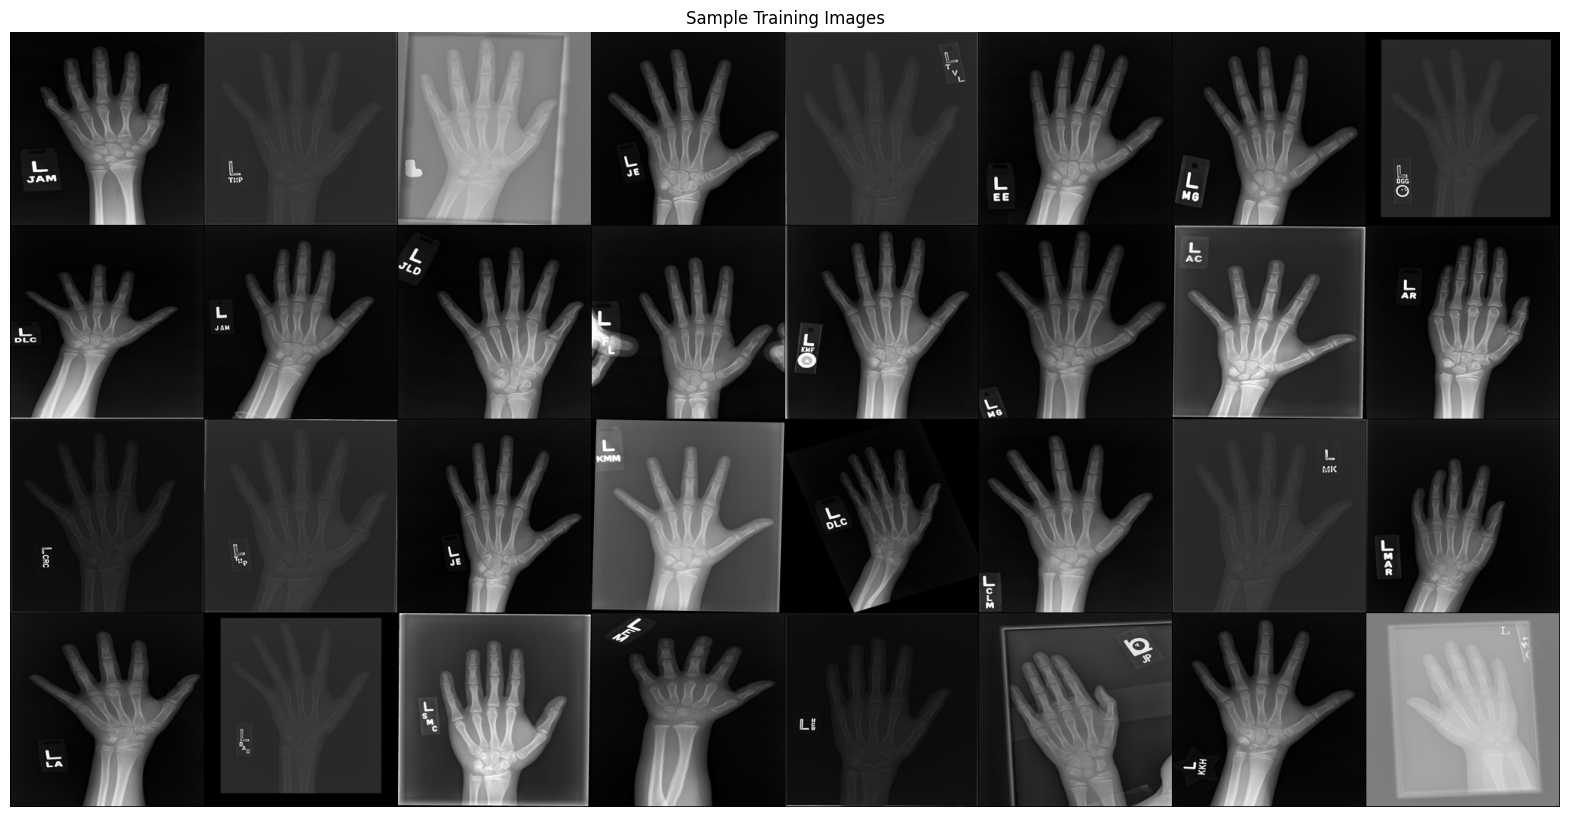

In [15]:

# Plot samples
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

sample_batch = next(iter(trainig_data_loader))
plt.figure(figsize=(20, 20)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

In [28]:
import torch
import torch.nn as nn

# Assuming you have a PyTorch dataset called 'dataset'

# Set random seed for reproducibility
torch.manual_seed(42)

# Define your PyTorch model
#model = YourModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Define the number of folds for cross-validation
num_folds = 5

# Calculate the size of each fold
fold_size = len(sample_batch) // num_folds

# Perform cross-validation
for fold in range(num_folds):
    print(f"Fold {fold+1}/{num_folds}")
    
    # Split the dataset into training and validation sets
    val_indices = range(fold * fold_size, (fold + 1) * fold_size)
    train_indices = [i for i in range(len(sample_batch)) if i not in val_indices]

    train_dataset = torch.utils.data.Subset(sample_batch, train_indices)
    val_dataset = torch.utils.data.Subset(sample_batch, val_indices)

    # Create data loaders for training and validation sets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Train the model
    train_losses = []
    val_losses = []
    for epoch in range(20):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = validation(model, device, trainig_data_loader,'Train')
        val_loss = validation(model, device, validation_data_loader,'Validation')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'val_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model_1.pth')

    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    # Calculate validation metrics
    val_accuracy = val_correct / val_total
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


Fold 1/5


TypeError: ignored

In [29]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 5.5 MB/s eta 0:00:00


In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
#from torchvision.datasets import MNIST
#from torchvision.models import resnet18
from torchvision.transforms import Compose, Normalize, ToTensor

from sklearn.model_selection import KFold
import numpy as np

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage

In [37]:
def initialize():
    model = BoneAgePredictor().to(device)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-06)
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, criterion

In [31]:
def setup_dataflow(dataset, train_idx, val_idx):
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=128, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=256, sampler=val_sampler)

    return train_loader, val_loader

In [38]:
def train_model(train_loader, val_loader):
    max_epochs = 3

    train_results = []
    val_results = []

    model, optimizer, criterion = initialize()

    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    evaluator = create_supervised_evaluator(model, metrics={"Accuracy": Accuracy(), "Loss": Loss(criterion)}, device=device)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        train_results.append(metrics)
        print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['Accuracy']:.2f} Avg loss: {metrics['Loss']:.2f}")


    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics
        val_results.append(metrics)

    trainer.run(train_loader, max_epochs=max_epochs) 

    return train_results, val_results

In [33]:
dataset = sample_batch

In [34]:
num_folds = 3
splits = KFold(n_splits=num_folds,shuffle=True,random_state=42)

In [39]:
results_per_fold = []

for fold_idx, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold_idx + 1))

    train_loader, val_loader = setup_dataflow(dataset, train_idx, val_idx)
    train_results, val_results = train_model(train_loader, val_loader)
    results_per_fold.append([train_results, val_results])

ERROR:ignite.engine.engine.Engine:Current run is terminating due to exception: stack expects each tensor to be equal size, but got [32, 1] at entry 0 and [32] at entry 1
ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: stack expects each tensor to be equal size, but got [32, 1] at entry 0 and [32] at entry 1


Fold 1


RuntimeError: ignored